In [1]:
# import
import os
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
from scipy.spatial import distance
from sklearn.cluster import KMeans
from tqdm import tqdm

# import plotting libraries
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
plt.rcParams['svg.fonttype'] = 'none'
import seaborn as sns
from nilearn import datasets
from nilearn import plotting

# import network_control functions
from network_control.energies import ComputeControlEnergy, integrate_u
from network_control.energies import optimal_input as get_control_inputs
from network_control.metrics import ave_control
from network_control.utils import matrix_normalization, convert_states_str2float, normalize_state, get_null_p
from network_control.plotting import roi_to_vtx, null_plot, surface_plot
from null_models.geomsurr import geomsurr

In [2]:
# directory where data is stored
datadir = '/Users/lindenmp/Google-Drive-Penn/work/research_projects/control_package/data'
resultsdir = '/Users/lindenmp/Google-Drive-Penn/work/research_projects/control_package/results'
A_file = 'pnc_schaefer200_Am.npy'
rsts_file = 'pnc_schaefer200_rsts.npy'

In [3]:
# load A matrix
A = np.load(os.path.join(datadir, A_file))
n_nodes = A.shape[0]
print(A.shape)

(200, 200)


In [4]:
# normalize
A[np.eye(A.shape[0]).astype(bool)] = 0
A_norm = matrix_normalization(A, version='continuous', c=1)

In [5]:
# load resting-state time series
rsts = np.load(os.path.join(datadir, rsts_file))

n_trs = rsts.shape[0]
n_nodes_rsts = rsts.shape[1]
n_subs = rsts.shape[2]
print('n_trs, {0}; n_nodes, {1}; n_subs, {2}'.format(n_trs, n_nodes_rsts, n_subs))

rsts_concat = np.zeros((n_trs * n_subs, n_nodes_rsts))
print(rsts_concat.shape)

for i in np.arange(n_subs):
    # z score subject i's time series
    rsts_z = sp.stats.zscore(rsts[:, :, i], axis=0)

    start_idx = i * n_trs
    end_idx = start_idx + n_trs
    rsts_concat[start_idx:end_idx, :] = rsts_z

n_trs, 120; n_nodes, 200; n_subs, 253
(30360, 200)


(5, 200)


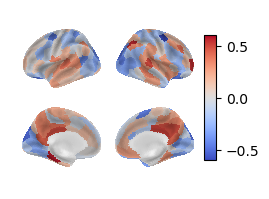

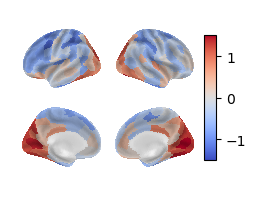

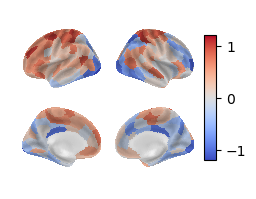

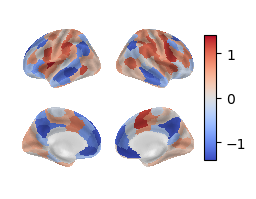

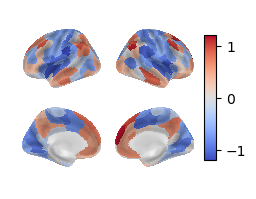

In [6]:
# extract 5 clusters of activity
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(rsts_concat)

# extract cluster centers. These represent dominant patterns of recurrent activity over time
centroids = kmeans.cluster_centers_
print(centroids.shape)

# plot centroids on brain surface
lh_annot_file = '/Users/lindenmp/Google-Drive-Penn/work/research_projects/connectome_loader/data/schaefer_parc/' \
                'fsaverage5/lh.Schaefer2018_200Parcels_7Networks_order.annot'
rh_annot_file = '/Users/lindenmp/Google-Drive-Penn/work/research_projects/connectome_loader/data/schaefer_parc/' \
                'fsaverage5/rh.Schaefer2018_200Parcels_7Networks_order.annot'
fsaverage = datasets.fetch_surf_fsaverage(mesh='fsaverage5')

for i in np.arange(n_clusters):
    f = surface_plot(data=centroids[i, :],
                     lh_annot_file=lh_annot_file, rh_annot_file=rh_annot_file,
                     fsaverage=fsaverage, order='lr', cmap='coolwarm')
    f.savefig(os.path.join(resultsdir, 'cluster_{0}.png'.format(i)), dpi=600, bbox_inches='tight', pad_inches=0.01)

In [7]:
# extract visual cluster is initial state
x0 = centroids[1, :]
# extract default mode cluster as target state
xf = centroids[4, :]

In [8]:
# normalize state magnitude
x0 = normalize_state(x0)
xf = normalize_state(xf)

In [9]:
# specify a uniform full control: all nodes are control nodes
# and all control nodes are assigned equal control weight
B = np.eye(n_nodes)

In [10]:
# set parameters
T = 1 # time horizon
rho = 1 # mixing parameter for state trajectory constraint
S = np.eye(n_nodes) # nodes in state trajectory to be constrained

# get the state trajectory (x) and the control inputs (u)
x, u, n_err = get_control_inputs(A_norm, T, B, x0, xf, rho, S)

[   0  200  400  600  800 1000]


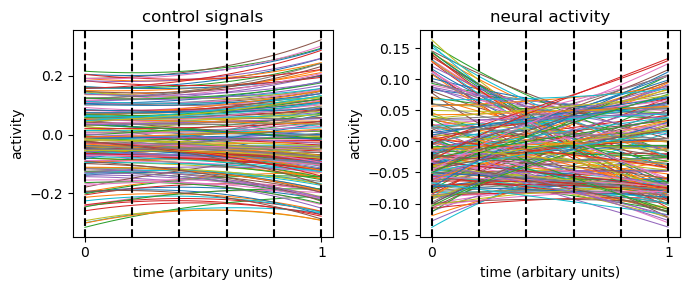

In [11]:
timepoints_to_plot = np.arange(0, x.shape[0], int(x.shape[0]/5))
print(timepoints_to_plot)

f, ax = plt.subplots(1, 2, figsize=(7, 3))
# plot control signals for initial state
ax[0].plot(u, linewidth=0.75)
ax[0].set_title('control signals')

# plot state trajectory for initial state
ax[1].plot(x, linewidth=0.75)
ax[1].set_title('neural activity')

for cax in ax.reshape(-1):
    cax.set_ylabel("activity")
    cax.set_xlabel("time (arbitary units)")
    cax.set_xticks([0, x.shape[0]])
    cax.set_xticklabels([0, T])

    for i in timepoints_to_plot:
        cax.axvline(x=i, color='black', linestyle='--')

f.tight_layout()
f.savefig(os.path.join(resultsdir, 'plot_xu_fmri.svg'), dpi=600, bbox_inches='tight', pad_inches=0.01)
plt.show()

In [12]:
# integrate control inputs to get control energy
node_energy = integrate_u(u)

# summarize nodal energy
energy = np.sum(node_energy)

print(energy)

2718.0096217104947


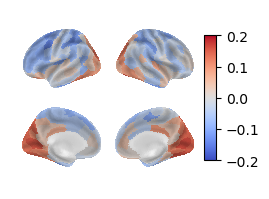

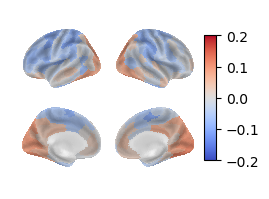

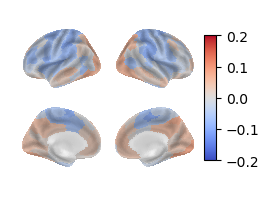

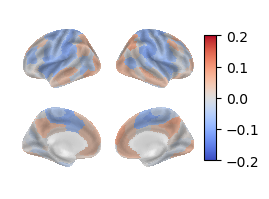

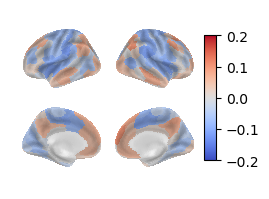

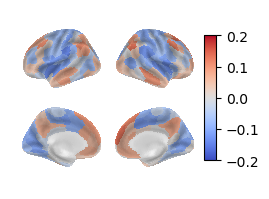

In [13]:
plot_u = False  # False for plotting x, True for plotting u

for i in timepoints_to_plot:
    if plot_u:
        data = u[i, :]
        vmax = 0.3
        vmin = -0.3
        fig_label = 'u_t{0}.png'.format(i)
    else:
        data = x[i, :]
        vmax = 0.2
        vmin = -0.2
        fig_label = 'x_t{0}.png'.format(i)

    f = surface_plot(data=data,
                     lh_annot_file=lh_annot_file, rh_annot_file=rh_annot_file,
                     fsaverage=fsaverage, order='lr',
                     cmap='coolwarm', cblim=[vmax, vmin])
    f.savefig(os.path.join(resultsdir, fig_label), dpi=600, bbox_inches='tight', pad_inches=0.01)